<a href="https://colab.research.google.com/github/Vishal281110/Market-Regimes-Classification-Using-Hidden-Markov-Models-HMM-/blob/main/FA_002(Market_Regimes_Classifcation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from scipy.special import logsumexp

# Data Cleaning, Feature Engineering and Exploratory Data Analysis


In [ ]:
df=pd.read_csv('INDIA VIX_minute.csv')

In [ ]:
df.isnull().sum()
df.dropna(inplace=True)

In [ ]:
df.head()


,date,open,high,low,close,volume
0,2015-01-09 09:15:00,16.47,16.47,14.46,15.39,0
1,2015-01-09 09:16:00,15.39,15.47,15.33,15.45,0
2,2015-01-09 09:17:00,15.45,15.51,15.41,15.46,0
3,2015-01-09 09:18:00,15.46,15.50,15.33,15.40,0
4,2015-01-09 09:19:00,15.39,15.40,15.29,15.35,0


In [ ]:
df.tail()

,date,open,high,low,close,volume
938690,2025-03-05 11:26:00,13.64,13.65,13.61,13.62,0
938691,2025-03-05 11:27:00,13.62,13.64,13.61,13.62,0
938692,2025-03-05 11:28:00,13.61,13.62,13.59,13.59,0
938693,2025-03-05 11:29:00,13.59,13.62,13.58,13.60,0
938694,2025-03-05 11:30:00,13.61,13.61,13.59,13.60,0


In [ ]:

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)




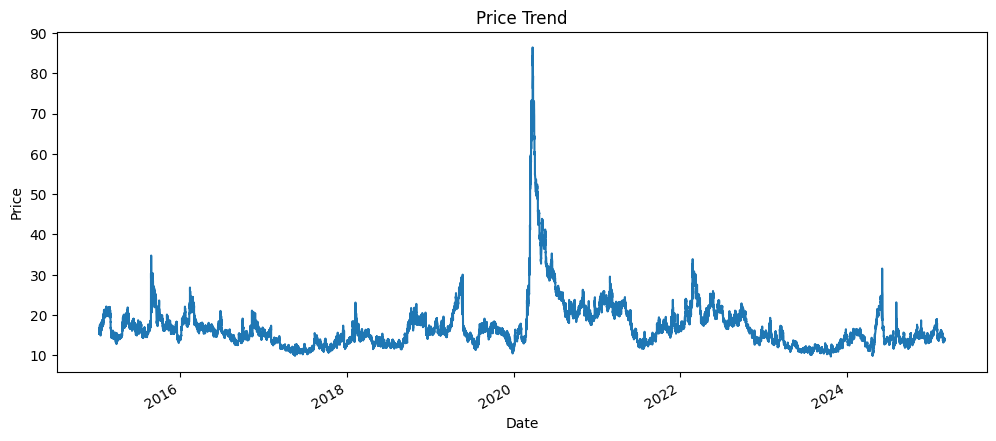

In [ ]:
import matplotlib.pyplot as plt

df['close'].plot(figsize=(12, 5), title='Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


<Axes: title={'center': 'Log Returns'}, xlabel='date'>

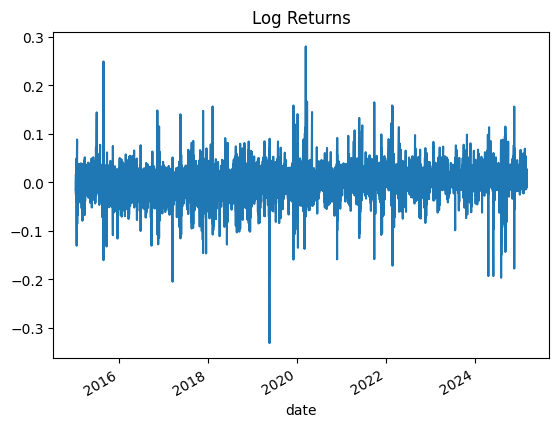

In [ ]:
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['log_return'].plot(title='Log Returns')



<Axes: title={'center': '7-Day Rolling Volatility'}, xlabel='date'>

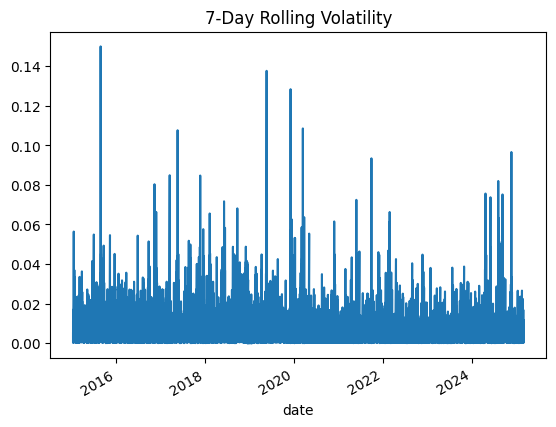

In [ ]:
df['volatility'] = df['log_return'].rolling(window=7).std()
df['volatility'].plot(title='7-Day Rolling Volatility')


In [ ]:
df[['log_return', 'volatility']].describe()


,log_return,volatility
count,9.386940e+05,938688.000000
mean,-1.317236e-07,0.002323
std,3.695517e-03,0.002987
min,-3.315732e-01,0.000000
25%,-1.101928e-03,0.001182
50%,0.000000e+00,0.001709
75%,1.084011e-03,0.002513
max,2.803668e-01,0.149998


The original dataset was too large to process efficiently, especially for basic operations like feature engineering and model fitting. To address this, we increased the time interval of the time series (e.g., from 1-minute to 60-minute data) to reduce the number of data points. This resampling significantly improves computational speed, reduces memory usage, and helps in smoother regime detection by filtering out high-frequency noise. Additionally, higher timeframes often reveal more stable long-term patterns, which are ideal for models like Hidden Markov Models (HMMs).

In [ ]:
# Load your data
df = pd.read_csv('INDIA VIX_minute.csv')

# Convert 'date' column to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


# Resample to 20-minute intervals
ohlcv_dict = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}
df_10min = df.resample('60T').agg(ohlcv_dict).dropna()

# Save to new CSV
df_10min.to_csv('INDIA VIX_60minute.csv')

# HMM Implementation Forward Backward Algorithm and Viterbi

The Da

Forward Algorithm - It computes the total probability of observing a sequence given the model — i.e., it estimates the log-likelihood of the observed data under the current HMM parameters.

It calculates αₜ(i) — the probability of observing the first t observations and ending in state i.

This is done recursively, using:

Initial probabilities (π)

Transition probabilities (A)

Emission probabilities (P(obs | state))

Backward algorithm - It calculates the probability of observing the future sequence of data, starting from each hidden state at time t. It is used during the E-step of the EM algorithm to help estimate the hidden states more accurately.

Initialize Parameter - Provides a reasonable and randomized starting point for the EM algorithm to begin learning

Log Emission Probs - Needed for the forward/backward steps to evaluate how likely an observation is under each hidden state.

Expectation Step - This function performs the E-step of the EM algorithm in an HMM.
It calculates the hidden state probabilities (γ and ξ) needed to update the model in the next step.

Maximization Step - This function performs the M-step of the EM algorithm in an HMM.
It updates the model parameters (initial probabilities, transition matrix, emission means & stds) using the expected values computed in the E-step (γ and ξ).



Fit - This method trains the HMM using the EM (Expectation-Maximization) algorithm.
It iteratively improves the model to maximize the likelihood of the observed data until convergence or a set number of iterations.

In [ ]:
class MarketRegimeHMM:
    """
    Hidden Markov Model with robust log-domain computations:
      - Forward/backward in log-space via log-sum-exp
      - E-step uses log-alpha/log-beta for gamma/xi
      - M-step performs true MLE updates with floors and re-normalization
      - Ensures monotonic log-likelihood; raises if it ever decreases
    """
    def __init__(self, n_states=3, random_state=42):
        np.random.seed(random_state)
        self.n_states = n_states

        # Model parameters
        self.initial_probs   = None  # π
        self.transition_matrix = None  # A
        self.emission_means  = None  # μ
        self.emission_stds   = None  # σ

        # Log-domain caches
        self.log_initial    = None
        self.log_transition = None

        # Posterior
        self.gamma = None

        # Numerical floors
        self.eps     = 1e-12
        self.min_std = 1e-6

        self.viterbi_path = None

    def initialize_parameters(self, observations):
        T, F = observations.shape

        # Transition matrix
        A = np.random.rand(self.n_states, self.n_states)
        A /= A.sum(axis=1, keepdims=True)
        self.transition_matrix = A

        # Initial probabilities
        pi = np.full(self.n_states, 1.0/self.n_states) + self.eps
        pi /= pi.sum()
        self.initial_probs = pi

        # Emission Gaussians
        data_min   = observations.min(axis=0)
        data_max   = observations.max(axis=0)
        data_range = np.maximum(data_max - data_min, self.min_std)

        means = np.zeros((self.n_states, F))
        stds  = np.zeros((self.n_states, F))
        for i in range(self.n_states):
            frac = (i+1)/(self.n_states+1)
            means[i] = data_min + frac*data_range
            stds[i]  = np.maximum(data_range/4, self.min_std)

        self.emission_means = means
        self.emission_stds  = stds

        # Cache log-domain transition & initial
        self.log_initial    = np.log(self.initial_probs + self.eps)
        self.log_transition = np.log(self.transition_matrix + self.eps)

    def log_emission_probs(self, obs):
        """Compute log b_j(obs) for each state j."""
        return np.array([
            np.sum(norm.logpdf(obs,
                                loc=self.emission_means[j],
                                scale=self.emission_stds[j]))
            for j in range(self.n_states)
        ])

    def forward_algorithm(self, observations):
        T, _ = observations.shape
        log_alpha = np.zeros((T, self.n_states))

        # t=0
        log_em0 = self.log_emission_probs(observations[0])
        log_alpha[0] = self.log_initial + log_em0

        # t=1..T-1
        for t in range(1, T):
            log_em = self.log_emission_probs(observations[t])
            L = log_alpha[t-1][:, None] + self.log_transition  # shape=(N,N)
            log_alpha[t] = logsumexp(L, axis=0) + log_em


        log_likelihood = logsumexp(log_alpha[-1])
        print(f"[FORWARD] log-likelihood = {log_likelihood:.6f}")
        self._log_alpha = log_alpha
        return log_alpha, log_likelihood

    def backward_algorithm(self, observations):
        T, _ = observations.shape
        log_beta = np.zeros((T, self.n_states))

        # t=T-1: stays zero (log(1))
        for t in range(T-2, -1, -1):
            log_em = self.log_emission_probs(observations[t+1])
            for i in range(self.n_states):
                L = self.log_transition[i] + log_em + log_beta[t+1]
                log_beta[t, i] = logsumexp(L)
            step = T - t


        print("[BACKWARD] complete")
        self._log_beta = log_beta
        return log_beta

    def expectation_step(self, observations, log_alpha, log_beta):
        T, _ = observations.shape
        gamma = np.zeros((T, self.n_states))
        xi    = np.zeros((T-1, self.n_states, self.n_states))

        # γ
        for t in range(T):
            L = log_alpha[t] + log_beta[t]
            log_den = logsumexp(L)
            gamma[t] = np.exp(L - log_den)

        # ξ
        for t in range(T-1):
            log_em = self.log_emission_probs(observations[t+1])
            M = (log_alpha[t][:, None]
                 + self.log_transition
                 + log_em[None, :]
                 + log_beta[t+1][None, :])
            log_den = logsumexp(M.ravel())
            xi[t] = np.exp(M - log_den)

        print(f"[E-STEP] avg γ-sum = {gamma.sum(axis=1).mean():.6f}")
        return gamma, xi

    def maximization_step(self, observations, gamma, xi):
        T, F = observations.shape

        # π
        pi = gamma[0] + self.eps
        pi /= pi.sum()
        self.initial_probs = pi

        # A
        A = np.zeros_like(self.transition_matrix)
        for i in range(self.n_states):
            denom = gamma[:-1, i].sum() + self.eps
            for j in range(self.n_states):
                A[i, j] = xi[:, i, j].sum() / denom
        A /= A.sum(axis=1, keepdims=True)
        self.transition_matrix = A

        # Emissions
        for i in range(self.n_states):
            w = gamma[:, i]
            W = w.sum() + self.eps
            mu = (w[:, None] * observations).sum(axis=0) / W
            dif = observations - mu
            var = (w[:, None] * (dif**2)).sum(axis=0) / W
            sigma = np.sqrt(np.maximum(var, self.min_std**2))
            self.emission_means[i] = mu
            self.emission_stds[i]  = sigma

        # Refresh log-domain caches
        self.log_initial    = np.log(self.initial_probs + self.eps)
        self.log_transition = np.log(self.transition_matrix + self.eps)

        print("\n[M-STEP] Updated parameters:")
        print(" π:", np.round(self.initial_probs,4))
        print(" A:\n", np.round(self.transition_matrix,4))
        print(" μ:\n", np.round(self.emission_means,4))
        print(" σ:\n", np.round(self.emission_stds,4))


    def viterbi(self, observations):
      T, _ = observations.shape
      log_delta = np.zeros((T, self.n_states))
      psi = np.zeros((T, self.n_states), dtype=int)

      # Initialization
      log_em0 = self.log_emission_probs(observations[0])
      log_delta[0] = self.log_initial + log_em0

      # Recursion
      for t in range(1, T):
          log_em = self.log_emission_probs(observations[t])
          for j in range(self.n_states):
              seq_probs = log_delta[t-1] + self.log_transition[:, j]
              psi[t, j] = np.argmax(seq_probs)
              log_delta[t, j] = np.max(seq_probs) + log_em[j]

      # Backtrack
      states = np.zeros(T, dtype=int)
      states[-1] = np.argmax(log_delta[-1])

      log_prob = np.max(log_delta[-1])

      print(f"[VITERBI] Most likely path log-probability: {log_prob:.6f}")

      self.viterbi_path = states
      for t in reversed(range(T - 1)):
          states[t] = psi[t + 1, states[t + 1]]

      return states, log_prob


    def predict_states(self, observations=None):
      if observations is not None:
            # Use Viterbi for new observations
            states, _ = self.viterbi(observations)
            return states, "viterbi"
      else:
            # Use stored results from training
            if self.viterbi_path is not None:
                return self.viterbi_path, "viterbi_cached"
            elif self.gamma is not None:
                # Fallback to posterior decoding
                states = np.argmax(self.gamma, axis=1)
                return states, "posterior"
            else:
                raise ValueError("Model must be fitted before prediction")


    def fit(self, observations, max_iterations=100, tolerance=1e-6, compute_viterbi=True):
        self.initialize_parameters(observations)
        log_likelihoods = []

        for it in range(max_iterations):
            print(f"\n=== EM Iteration {it+1}/{max_iterations} ===")
            log_alpha, ll = self.forward_algorithm(observations)
            log_beta      = self.backward_algorithm(observations)
            gamma, xi     = self.expectation_step(observations, log_alpha, log_beta)
            self.gamma    = gamma
            self.maximization_step(observations, gamma, xi)

            if it > 0 and ll < log_likelihoods[-1]:
                raise RuntimeError(
                    f"Log-likelihood decreased "
                    f"{log_likelihoods[-1]:.6f}→{ll:.6f}; instability."
                )

            log_likelihoods.append(ll)
            improvement = ll - (log_likelihoods[-2] if it>0 else ll)
            print(f"Log-likelihood: {ll:.6f}  Improvement: {improvement:.6f}")

            if it>0 and improvement < tolerance:
                print(f"Converged after {it+1} iterations")
                break

        print("\n[FIT] Training completed")

        if compute_viterbi:
            print("\n[FIT] Computing Viterbi path...")
            self.viterbi(observations)


        return log_likelihoods

    def decode(self, observations, method="viterbi"):
      if method == "viterbi":
            states, log_prob = self.viterbi(observations)
            return states, np.exp(log_prob)
      elif method == "posterior":
            log_alpha, _ = self.forward_algorithm(observations)
            log_beta = self.backward_algorithm(observations)
            gamma, _ = self.expectation_step(observations, log_alpha, log_beta)
            states = np.argmax(gamma, axis=1)
            confidence = np.max(gamma, axis=1)
            return states, confidence
      else:
            raise ValueError("Method must be 'viterbi' or 'posterior'")



Parameter Initialisation (Parameters are Transition matrix, Initial state probability matrix and emission parametrs i.e mean and standard deviation of return and volatility in each state which will be used to calculate emission probabilities)

Implementation of Forward Algorithm
Here, we are going to calculate forward probabilities by calculating emission probabilities and multiplying them with initial state probabilities

# Apply HMM

In [ ]:
def apply_hmm_to_ohlcv(df, n_states=3, features=['returns', 'volatility'],
                        lookback=10, max_iter=1000, tolerance=1e-6, random_state=42, decode_method="posterior"):


      # 1. Feature Engineering
      feature_arrays = []
      feature_names = []

      if 'returns' in features:
          returns = df['close'].pct_change().fillna(0)
          feature_arrays.append(returns.values)
          feature_names.append('returns')

      if 'volatility' in features:
          if 'returns' not in locals():
              returns = df['close'].pct_change().fillna(0)
          volatility = returns.rolling(lookback).std().fillna(0)
          feature_arrays.append(volatility.values)
          feature_names.append('volatility')

      if 'range' in features:
          price_range = (df['high'] - df['low']) / df['open']
          feature_arrays.append(price_range.values)
          feature_names.append('range')

      if 'volume' in features:
          volume = df['volume'].pct_change().fillna(0)
          feature_arrays.append(volume.values)
          feature_names.append('volume')

      # Create observation matrix
      observations = np.column_stack(feature_arrays)

      # 2. Initialize and train HMM model
      model = MarketRegimeHMM()
      model.fit(observations, max_iterations=max_iter, tolerance=tolerance, compute_viterbi=True)

      # 3. Predict regimes
      states = np.argmax(model.gamma, axis=1)
      probs = np.max(model.gamma, axis=1)

      # 3. Predict regimes
      states_viterbi = np.argmax(model.gamma, axis=1)
      probs_viterbi = np.max(model.gamma, axis=1)


      states_viterbi, confidence = model.decode(observations, method="viterbi")
      # For Viterbi, confidence is the total path probability
      probs_viterbi = np.full(len(states), confidence)  # Same for all time steps

      states, probs = model.decode(observations, method="posterior")

      # 5. Prepare output DataFrame
      df_out = df.copy()
      df_out['regime'] = states
      df_out['regime_prob'] = probs
      df_out['decode_method'] = decode_method

      # 5. Prepare output DataFrame
      df_out_viterbi = df.copy()
      df_out_viterbi['regime'] = states
      df_out_viterbi['regime_prob'] = probs
      df_out_viterbi['decode_method'] = decode_method


      # Store both gamma (if available) and viterbi path
      if model.gamma is not None:
          df_out['gamma'] = list(model.gamma)
      if model.viterbi_path is not None:
          df_out['viterbi_path'] = model.viterbi_path

      persistence_df = regime_persistence_analysis(
        states=states,
        transition_matrix=model.transition_matrix,
        state_names=[f"State {i}" for i in range(n_states)]
    )



      # Add feature columns to output
      for i, name in enumerate(feature_names):
          df_out[name] = observations[:, i]

      return model, df_out, df_out_viterbi, persistence_df



# Regime Validation

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score

def validate_regime_identification(result_df, regime_labels):
    # Step 1: Define market events (example: VIX > 95th percentile)
    vix_threshold_95 = result_df['close'].quantile(0.95)
    event = (result_df['close'] > vix_threshold_95).astype(int)

    # Step 2: Cross-tabulate regime vs. event
    crosstab = pd.crosstab(result_df['regime'], event)

    # Step 3: Chi-square test
    chi2, p, _, _ = chi2_contingency(crosstab)

    # Step 4: Simple score: significant if p < 0.05, else not.
    validation_score = 1.0 if p < 0.05 else 0.0

    # Optionally, use event incidence to relabel regimes
    event_rate_by_regime = crosstab[1] / crosstab.sum(axis=1)
    sorted_regimes = event_rate_by_regime.sort_values(ascending=False).index.tolist()
    enhanced_labels = {r: l for r, l in zip(sorted_regimes, ['High VIX', 'Medium VIX', 'Low VIX'])}

    return {
        'validation_score': validation_score,
        'p_value': p,
        'crosstab': crosstab,
        'enhanced_labels': enhanced_labels,
    }


# Regime persistence Analysis

In [ ]:
import numpy as np
import pandas as pd

def regime_persistence_analysis(states, transition_matrix, state_names=None):
    """
    Compute persistence metrics: persistence probability, duration consistency,
    stability index, and time proportion for each hidden state.

    Parameters
    ----------
    states : array-like of int or str
        Sequence of decoded hidden states (e.g., from Viterbi).
    transition_matrix : 2D numpy.ndarray
        Square matrix of shape (n_states, n_states) with transition probabilities.
    state_names : list of str, optional
        Names of the states. If None, states are named 0, 1, 2, ...

    Returns
    -------
    pandas.DataFrame
        A DataFrame indexed by state with columns:
          - persistence_prob : self-transition probability (p_ii)
          - mean_duration      : average empirical duration
          - std_duration       : standard deviation of durations
          - duration_consistency: inverse coefficient of variation (mean/ std)
          - time_proportion    : fraction of total time in this state
          - stability_index    : composite metric
    """
    # Prepare state labels
    states = np.asarray(states)
    unique_states = np.unique(states)
    if state_names is None:
        state_labels = unique_states
        state_name_map = {s: str(s) for s in unique_states}
    else:
        # Ensure state_names aligns with unique_states if provided
        if len(state_names) != len(unique_states):
             raise ValueError("Length of state_names must match number of unique states.")
        state_labels = unique_states
        state_name_map = {state: name for state, name in zip(unique_states, state_names)}


    n = len(state_labels)
    # 1. Persistence probability (p_ii from transition_matrix)
    # Ensure transition_matrix indices align with unique_states
    persistence_prob = np.diag(transition_matrix)

    # 2. Extract durations for each state
    durations = {label: [] for label in state_labels}
    if len(states) > 0:
      current_state = states[0]
      count = 1
      for s in states[1:]:
          if s == current_state:
              count += 1
          else:
              durations[current_state].append(count)
              current_state = s
              count = 1
      durations[current_state].append(count) # Append the last sequence


    # 3. Compute empirical duration stats
    mean_duration = np.array([np.mean(durations[label]) if durations[label] else 0 for label in state_labels])
    std_duration  = np.array([np.std(durations[label], ddof=1) if len(durations[label]) > 1 else 0 for label in state_labels])
    # 4. Duration consistency = mean / std
    duration_consistency = np.divide(mean_duration, std_duration, out=np.zeros_like(mean_duration), where=std_duration!=0)

    # 5. Time proportion
    total_time = len(states)
    time_proportion = np.array([sum(durations[label]) if durations[label] else 0 for label in state_labels]) / total_time if total_time > 0 else np.zeros_like(state_labels, dtype=float)

    # 6. Stability index = persistence probability * duration_consistency * time_proportion
    # Ensure persistence_prob is indexed correctly if state_labels are not 0, 1, ...
    # Assuming transition matrix rows/cols correspond to sorted unique_states
    stability_index = persistence_prob * duration_consistency * time_proportion

    # Assemble results
    df = pd.DataFrame({
        'persistence_prob': persistence_prob,
        'mean_duration': mean_duration,
        'std_duration': std_duration,
        'duration_consistency': duration_consistency,
        'time_proportion': time_proportion,
        'stability_index': stability_index
    }, index=[state_name_map[label] for label in state_labels]) # Use state names for index

    return df

# Regime Anamoly Detection

In [ ]:
def regime_anamoly_detection(result_df, probability_threshold=0.6):
    low_probability_anomalies = result_df[result_df['regime_prob'] < probability_threshold]
    print(f"\n Identified Anomalies (Regime Probability < {probability_threshold}):\n")
    print(low_probability_anomalies[['close', 'regime', 'regime_prob']])


    plt.figure(figsize=(14, 7))
    plt.plot(result_df.index, result_df['close'], label='Close Price', alpha=0.8)

    plt.scatter(low_probability_anomalies.index,
                low_probability_anomalies['close'],
                color='red',
                label=f'Anomalies (Prob < {probability_threshold})',
                zorder=5) # Ensure anomalies are on top

    plt.title('Close Price with Identified Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Implementation


=== EM Iteration 1/1000 ===
[FORWARD] log-likelihood = -9047.902232
[BACKWARD] complete
[E-STEP] avg γ-sum = 1.000000

[M-STEP] Updated parameters:
 π: [8.637e-01 1.362e-01 1.000e-04]
 A:
 [[6.382e-01 3.612e-01 6.000e-04]
 [9.407e-01 5.900e-02 2.000e-04]
 [1.438e-01 8.369e-01 1.920e-02]]
 μ:
 [[-0.0007  0.0164  0.033 ]
 [ 0.0023  0.0184  0.0384]
 [ 0.0593  0.0565  0.1447]]
 σ:
 [[0.0184 0.0103 0.0432]
 [0.0238 0.0131 0.1327]
 [0.1226 0.0432 0.62  ]]
Log-likelihood: -9047.902232  Improvement: 0.000000

=== EM Iteration 2/1000 ===
[FORWARD] log-likelihood = 132660.157997
[BACKWARD] complete
[E-STEP] avg γ-sum = 1.000000

[M-STEP] Updated parameters:
 π: [0.741 0.259 0.   ]
 A:
 [[0.786  0.2099 0.0042]
 [0.96   0.0362 0.0038]
 [0.0356 0.2909 0.6735]]
 μ:
 [[-0.001   0.0156  0.0251]
 [ 0.0043  0.0192  0.069 ]
 [ 0.0195  0.0736  0.1528]]
 σ:
 [[0.0134 0.0082 0.0213]
 [0.0284 0.0114 0.07  ]
 [0.0957 0.0235 0.6185]]
Log-likelihood: 132660.157997  Improvement: 141708.060230

=== EM Iteration 

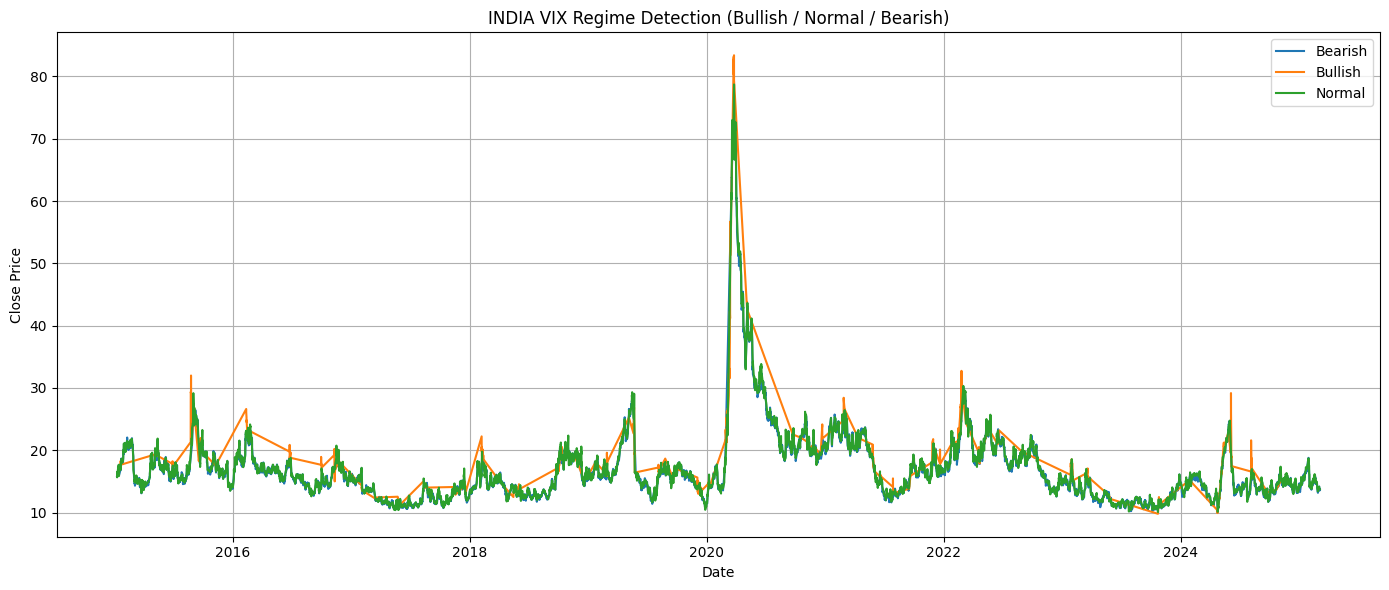


 Identified Anomalies (Regime Probability < 0.6):

                     close  regime  regime_prob
date                                           
2015-01-13 15:00:00  16.33       1     0.509225
2015-01-15 12:00:00  16.02       1     0.597835
2015-01-15 13:00:00  16.10       0     0.590854
2015-01-15 14:00:00  16.06       0     0.550408
2015-01-29 14:00:00  19.62       1     0.563283
...                    ...     ...          ...
2024-12-30 12:00:00  13.83       0     0.550025
2025-01-17 13:00:00  15.89       1     0.502923
2025-01-27 10:00:00  18.07       0     0.533421
2025-01-31 13:00:00  16.48       0     0.527436
2025-02-04 11:00:00  14.62       1     0.550508

[415 rows x 3 columns]


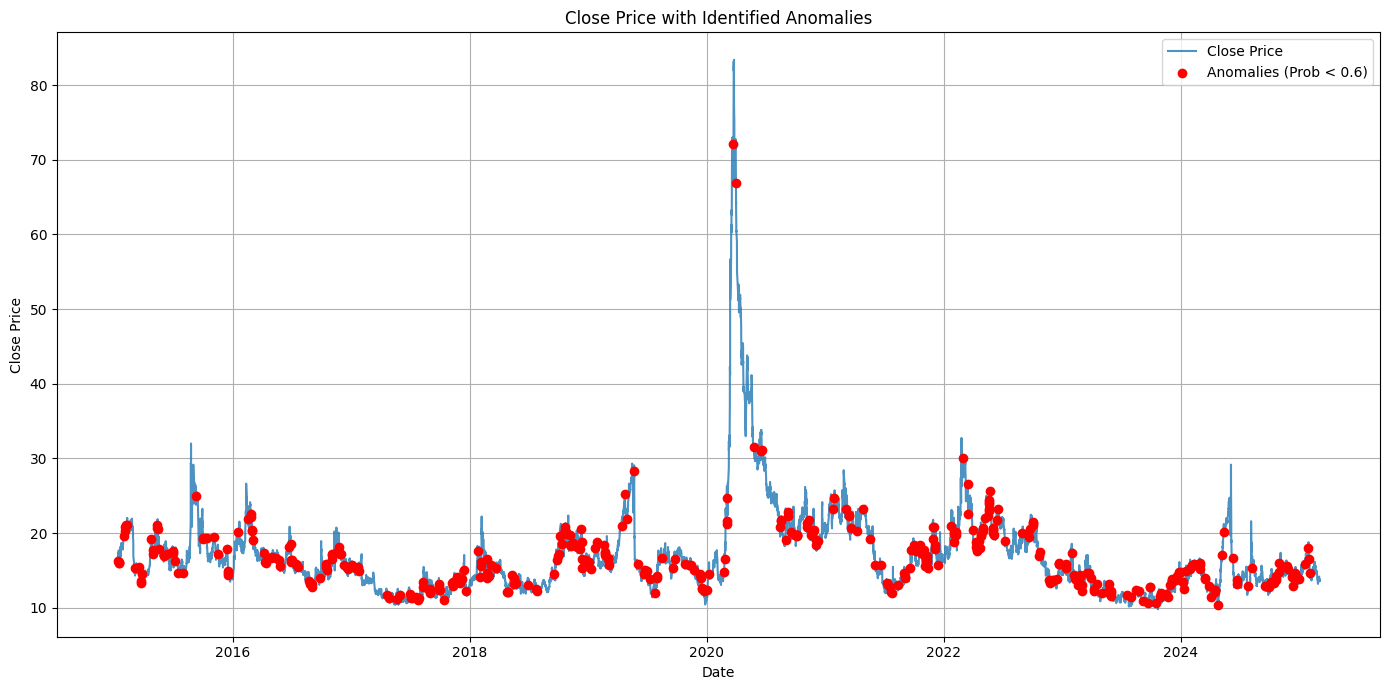

In [ ]:
# Step 1: Load financial data (OHLCV format)
df = pd.read_csv('INDIA VIX_60minute.csv', parse_dates=['date'], index_col='date')

# Step 2: Apply HMM to 3 features (returns, volatility, range)
model, result_df, result_df_viterbi, persistence_analysis_df = apply_hmm_to_ohlcv(
    df,
    n_states=3,
    features=['returns', 'volatility', 'range'],
    lookback=10,
    max_iter=1000,
    tolerance=1e-6,
    random_state=42
)

# Step 3: Analyze results
print(result_df[['close', 'regime', 'regime_prob']].tail())

print(persistence_analysis_df.tail())


# Step 4: Compute mean return per regime
summary = result_df.groupby('regime')['returns'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
print("\n📊 Regime Statistics:\n", summary)

# Step 5: Label regimes based on mean return
regime_order = summary.index.tolist()
labels = ['Bullish', 'Normal', 'Bearish']  # Highest mean = Bullish
regime_labels = {regime: label for regime, label in zip(regime_order, labels)}
result_df['regime_label'] = result_df['regime'].map(regime_labels)

# Step 6: Print regime-label mapping
print("\n📝 Regime Labels:")
for r, lbl in regime_labels.items():
    print(f"Regime {r} → {lbl}")

# NEW: Market Event Correlation Validation
validation_results = validate_regime_identification(result_df, regime_labels)


# Enhanced regime labels based on validation
if validation_results['validation_score'] >= 0.4:
    enhanced_regime_labels = validation_results['enhanced_labels']
    result_df['enhanced_regime_label'] = result_df['regime'].map(enhanced_regime_labels)



# Step 7: Plot with regime color coding
plt.figure(figsize=(14, 6))
for label, group in result_df.groupby('regime_label'):
    plt.plot(group.index, group['close'], label=label)
plt.title('INDIA VIX Regime Detection (Bullish / Normal / Bearish)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Regime Anamoly Detection
regime_anamoly_detection(result_df, probability_threshold=0.6)